<a href="https://colab.research.google.com/github/as9786/ParrotnlpJeju/blob/main/LSTM%2BCNN%2BELU_97_21_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전작업

In [ ]:
#필요한 모듈 불러오기
import pandas as pd  

from keras.layers import Dense,Input,Bidirectional,Conv1D,LSTM
from tensorflow.keras.layers import Embedding,GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, Flatten
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Model
from keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split 

import spacy

In [ ]:
#데이터
train_file = pd.read_csv('/content/drive/MyDrive/train.csv')
test_file = pd.read_csv('/content/drive/MyDrive/test.csv')

X_train = train_file["comment_text"].str.lower()
X_test = test_file["comment_text"].str.lower()

y_train = train_file[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [ ]:
print("X train shape : ", X_train.shape)
print("X test shape : ", X_test.shape)
print("y train shape : ", y_train.shape)

X train shape :  (159571,)
X test shape :  (153164,)
y train shape :  (159571, 6)


# 토큰화 작업하기

In [ ]:
max_features=200000
maxlen=200
embed_size=300

tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

# 모델 구성하기

In [ ]:
from tensorflow.compat.v1.keras.layers import CuDNNGRU, CuDNNLSTM
from tensorflow.keras.layers import LeakyReLU,Dropout,ELU

In [ ]:
input = Input(shape=(maxlen, )) 
layer = Embedding(max_features, embed_size)(input)
layer = SpatialDropout1D(0.2)(layer)
layer = Bidirectional(CuDNNLSTM(128, return_sequences=True))(layer)
layer =  Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(layer)   
avg_pool = GlobalAveragePooling1D()(layer)
max_pool = GlobalMaxPooling1D()(layer)
con = concatenate([avg_pool, max_pool])
layer= Dense(50)(con)
layer = ELU(alpha = 0.01)(layer)
layer = Dropout(0.25)(layer)
layer = Dense(6, activation = "sigmoid")(layer)
model = Model(inputs = input, outputs = layer)  
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     60000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 256)     440320      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
hist = model.fit(x_train,y_train,batch_size=32, epochs=2, validation_split = 0.2,verbose=1)

Epoch 1/2
3990/3990 [==============================] - 2203s 552ms/step - loss: 0.0545 - accuracy: 0.9515 - val_loss: 0.0473 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 2184s 547ms/step - loss: 0.0401 - accuracy: 0.9663 - val_loss: 0.0455 - val_accuracy: 0.9941


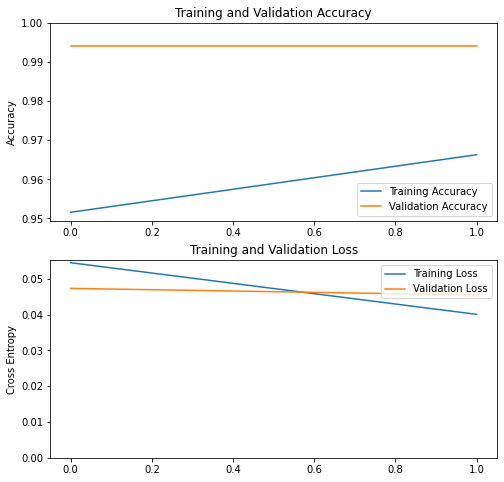

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/toxic1_model0401.h5')

In [ ]:
y_pred = model.predict(x_test,batch_size=32,verbose=1)

4787/4787 [==============================] - 51s 11ms/step


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('/content/drive/MyDrive/submission5.csv', index=False)